In [1]:
import numpy as np
from scipy.sparse import hstack, issparse
import scipy.linalg as sla
from scipy.sparse.linalg import expm
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score
from scipy.optimize.linesearch import scalar_search_wolfe2
from scipy.optimize import brent, golden
from tqdm.notebook import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import time
import scipy

import warnings
warnings.filterwarnings("ignore")

# Пункт 1.

$$
\begin{gathered}
loss(w) = - \frac{1}{N} (y * \log(\sigma(X w^T)) + (1 - y) * \log (\sigma (X w^T)) \\
\nabla loss(w) = \frac{1}{N} X^T * (\sigma(w^T X) - y) \\
\nabla^2 loss(w) = X (\sigma(w^T X)(1 - \sigma(w^T X))) X^T
\end{gathered}
$$

Будет ли зависеть результат работы
метода для логистической регрессии от выбора начальной точки?

Не будет зависеть, т.к. гессиан положительно определен, функция выпуклая.

# Пункт 2

## Оракул

In [2]:
class Oracle:

    def __init__(self, X, y):
        self.X = self.__extend_X(X)
        self.y = y
        self.__n_calls = 0
        self.eps = 1e-08
        self.N = self.y.shape[0]

    
    def start_count(self, W_init):
        self.__opt_score = self.__get_optimum_score(W_init)
        self.__init_grad = self.grad(W_init)
        self.__n_calls = 0
        self.__n_iter = 0
        self.__time = time.time()

        self.iter_array = []
        self.time_array = []
        self.calls_array = []
        self.scores_1 = []
        self.scores_2 = []
        self.entropy = []

    
    def __get_optimum_score(self, W_init):
        result = scipy.optimize.minimize(self.value, x0 = W_init, method='Newton-CG', 
                             jac=self.grad, hess=self.hessian)
        return self.value(result.x)


    def next_iteration(self, x):
        self.iter_array.append(self.__n_iter)
        self.calls_array.append(self.__n_calls)

        self.time_array.append(time.time() - self.__time)
        self.__n_iter += 1
        entropy = self.value(x) 

        score_1 = abs(entropy - self.__opt_score)
        score_2 = np.linalg.norm(self.grad(x)) ** 2 / np.linalg.norm(self.__init_grad) ** 2 
        self.scores_1.append(score_1)
        self.scores_2.append(score_2)
        self.entropy.append(entropy)


    def get_n_calls(self):
        return self.__n_calls


    def __extend_X(self, X):
        intercept = np.ones((X.shape[0], 1))
        if issparse(X):
            return hstack([intercept, X])
        else:
            return np.hstack([intercept, X])


    def __sigmoid(self, z):
        return 1 / (1 + np.exp(-z))


    def get_prob(self, w):
        p = self.__sigmoid(self.X @ w.T)
        return np.clip(p, 1e-10, 1 - 1e-10)


    def value(self, w):
        p = self.get_prob(w)
        self.__n_calls += 1

        return -(self.y * np.log(p + self.eps) + (1 - self.y) * np.log(1 - p + self.eps)).mean()


    def grad(self, w):
        p = self.get_prob(w)
        self.__n_calls += 1

        return self.X.T @ (p - self.y) / self.N

    def hessian(self, w):
        p = self.get_prob(w)
        self.__n_calls += 1

        return self.X.T @ np.diag(p * (1 - p)) @ self.X / self.N

    def hessian_vec_product(self, w, d):
        p = self.get_prob(w)
        self.__n_calls += 1
        result = (self.X @ d)
        result = np.diag(p * (1 - p)) @ result
        result = self.X.T @ result

        return result / self.N


    def fuse_value_grad(self, x):
        return self.value(x), self.grad(x)


    def fuse_value_grad_hessian(self, x):
        return self.value(x), self.grad(x), self.hessian(x)


    def fuse_value_grad_hessian_vec_product(self, x, d):
        return self.value(x), self.grad(x), self.hessian_vec_product(x, d)

## Загрузка датасетов

In [3]:
def make_oracle (data_path) :
    if not data_path == 'random':
        X, y = load_svmlight_file(data_path)
        
        nums = list(set(y))
        for i in range(len(nums)):
            y[y == nums[i]] = i

        print('Dataset shape: ', X.shape, y.shape)        

        return Oracle(X, y)
     
    a, b = np.random.uniform(-1, 1, 2)
    X = (a * np.random.normal(0, 1, 1000) + b)
    y = np.apply_along_axis(lambda  x: (x >= 0).astype(np.int), 0, X)
    X = X.reshape(-1, 1)
    print('Dataset shape: ', X.shape, y.shape)
    print('Unique:', np.unique(y))

    return Oracle(X, y)

## Разностная проверка оракула

In [4]:
oracle = make_oracle('random')

Dataset shape:  (1000, 1) (1000,)
Unique: [0 1]


In [5]:
def check_grad(oracle):
    '''
    Разностная проверка градиента
    '''
    W = np.random.normal(0, 1, size=(oracle.X.shape[1]))

    # Берем порядок eps < -15, т.к. на этой точности 
    # часто возникает переполнение
    # Рекомендованным значением является корень из машинной точности
    eps = 10 ** (-8)

    errors = []
    true_grad = oracle.grad(W)
    
    for i in range(oracle.X.shape[1]):
        e_i = np.zeros(oracle.X.shape[1])
        e_i[i] = 1
        dif_grad = (oracle.value(W + eps * e_i) - oracle.value(W)) / eps
        errors.append(abs(dif_grad - true_grad[i]))

    return np.mean(errors)

check_grad(oracle)

1.7583416736521862e-09

In [6]:
def check_hessian(oracle):
    '''
    Разностная проверка градиента
    '''
    W = np.random.normal(0, 1, size=(oracle.X.shape[1]))
    eps = 10 ** (-8)
    errors = []
    true_hessian = oracle.hessian(W)

    for i in range(oracle.X.shape[1]):
        for j in range(oracle.X.shape[1]):
            e_i = np.zeros(oracle.X.shape[1])
            e_i[i] = 1

            dif_hessian = (oracle.grad(W + eps * e_i) - oracle.grad(W)) / eps

            errors.append(abs(dif_hessian - true_hessian[i]).mean())

    return np.mean(errors)

check_hessian(oracle)

7.828775118630393e-09

Видно, что разница между методом разностного дифференцирования и методом зи оракула очень маленькая - порядка e-08. Это означает, что гессиан и градиент находятся правильно.

# Пункт 3.

## Реализация Line Search

In [7]:
class LineSearch:

    def __init__(self, oracle, name = 'wolfe', 
                 c_armijo = 0.4, c1_wolfe=0.4, c2_wolfe=0.9):
        self.c_armijo = c_armijo
        self.c1_wolfe = c1_wolfe
        self.c2_wolfe = c2_wolfe
        self.oracle = oracle
        self.__method = name

    
    def line_search(self, x, direction, a_start=100):
        value = lambda a: self.oracle.value(x + a * direction)
        grad = lambda a: self.oracle.grad(x + a * direction).T @ direction
        
        if self.__method == 'armijo':
            return self.__armijo(value, grad, a_start)
        elif self.__method == 'wolfe':
            result = scalar_search_wolfe2(value, grad,
                                          phi0=a_start, 
                                          c1=self.c1_wolfe, c2=self.c2_wolfe)[0]

            if result is None:
                return self.__armijo(value, grad, a_start)
            return result
        elif self.__method == 'brent':
            return brent(value)
        elif self.__method == 'golden':
            return golden(value)
        elif self.__method == 'nesterov':
            return self.__nesterov(x, direction)


    def __armijo(self, value, grad, a_start, maxiter=100):
        a = a_start
        c = self.c_armijo

        for i in range(maxiter):
            if value(a) <= value(0) + c * a * grad(0):
                break

            a = a / 2

        return a

    
    def __nesterov(self, x, direction, maxiter=1000):
        L = 0.01

        for i in range(maxiter):
            x_next = x + 1 / L * direction

            if self.oracle.value(x_next) <= self.oracle.value(x) + \
                    self.oracle.grad(x).T @ (x_next - x) + \
                    L / 2 * np.linalg.norm(x_next - x) ** 2:
                break

            L = L * 2

        L = L / 2
        return 1 / L

## Начальное значение

In [8]:
def init_weights(shape, start_type='zeros'):
    if start_type == 'zeros':
        return np.zeros(shape)
    if start_type == 'ones':
        return np.ones(shape)
    if start_type == 'random':
        return np.random.uniform(0, 1, shape)

## Анализ методов

In [9]:
def analyze(data_path, opt_method, start_type='zeros', nesterov=True, graph=True):
    oracle = make_oracle(data_path)
    start_point = init_weights(oracle.X.shape[1], start_type)

    line_search_methods = ['golden', 'wolfe', 'brent', 'armijo']
    if nesterov:
        line_search_methods.append('nesterov')

    dict_time = {}
    dict_iters = {}
    dict_calls = {}
    dict_scores_1 = {}
    dict_scores_2 = {}
    dict_entropy = {}

    for line_search in tqdm(line_search_methods):
        ls = LineSearch(oracle, line_search)
        _ = opt_method(oracle, start_point, ls)

        dict_time[line_search] = oracle.time_array
        dict_iters[line_search] = oracle.iter_array
        dict_calls[line_search] = oracle.calls_array
        dict_scores_1[line_search] = oracle.scores_1
        dict_scores_2[line_search] = oracle.scores_2
        dict_entropy[line_search] = oracle.entropy

    table = []
    for line_search in line_search_methods:
        row = {}
        row['Method'] = line_search
        row['Entropy'] = dict_entropy[line_search][-1]
        row['Num Iter'] = dict_iters[line_search][-1]
        row['Oracle Calls'] = dict_calls[line_search][-1]
        row['Time'] = int(dict_time[line_search][-1] * 100) / 100
        table.append(row)

    print(tabulate(table, headers="keys", tablefmt="github"))

    if graph:
        for line_dict, name in [(dict_time, 'Time'), (dict_iters, 'Iterations'), (dict_calls, 'Calls')]:
            _, axes = plt.subplots(nrows=1, ncols=2, figsize=(22,4))

            for line_search in line_search_methods:
                axes[0].plot(line_dict[line_search], np.log(dict_scores_1[line_search]), label=line_search);
                axes[1].plot(line_dict[line_search], np.log(dict_scores_2[line_search]), label=line_search);

            axes[0].legend()
            axes[0].set_xlabel(name)
            axes[0].set_ylabel('log|F(w) - F(w*)|')
            axes[1].legend()
            axes[1].set_xlabel(name)
            axes[1].set_ylabel('log(|grad F(w)|^2 / |grad F(w_0)|^2)')

            plt.suptitle(name)
            plt.show()

## Градиентный спуск

In [10]:
def optimize(f, start_point, line_search, tol=1e-08, max_iter=10000):

    W_init = start_point
    W_init_grad = f.grad(W_init)

    W = W_init.copy()
    W_grad = W_init_grad.copy()

    f.start_count(W_init)

    for k in range(max_iter + 1):
        if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < tol:
            break

        direction = -W_grad
        a = line_search.line_search(W, direction)
        W += a * direction

        W_loss, W_grad = f.fuse_value_grad(W)

        f.next_iteration(W)

    return W

## Анализ работы условия Армихо

c1 для условия Армихо находится в промежутке (0, 0.5)

In [11]:
oracle = make_oracle('a1a.txt')
start_point = init_weights(oracle.X.shape[1], 'ones')
table = []

for c in tqdm(np.arange(0.1, 0.5, 0.1)):
    ls = LineSearch(oracle, 'armijo', c_armijo=c)
    W = optimize(oracle, start_point, ls)

    row = {}
    row['c'] = c
    row['Entropy'] = oracle.entropy[-1]
    row['Num Iter'] = oracle.iter_array[-1]
    row['Time'] = oracle.time_array[-1]
    row['Calls'] = oracle.calls_array[-1]

    table.append(row)

print(tabulate(table, headers="keys", tablefmt="github"))

Dataset shape:  (1605, 119) (1605,)



|   c |   Entropy |   Num Iter |    Time |   Calls |
|-----|-----------|------------|---------|---------|
| 0.1 |  0.298512 |      10000 | 64.2097 |  218658 |
| 0.2 |  0.298479 |      10000 | 63.5509 |  217722 |
| 0.3 |  0.298466 |      10000 | 64.0611 |  217536 |
| 0.4 |  0.298435 |      10000 | 63.4881 |  217104 |


Видно, что выбор парамтре сильно не влияет на производительность, но есть зависимость, что чем больше условие Армихо, тем меньше вызовов оракула и быстрее работает метод.

## Анализ работы условия Вульфа

$с_1 \in (0, 0.5), c_2 \in (c_1, 1)$

In [12]:
oracle = make_oracle('a1a.txt')
start_point = init_weights(oracle.X.shape[1], 'ones')
table = []

c_1 = 0.4
for c_1 in [0.1, 0.4]:
    for c_2 in [c_1 + 0.1, 0.9]:
        ls = LineSearch(oracle, 'wolfe', c1_wolfe=c_1, c2_wolfe=c_2)
        W = optimize(oracle, start_point, ls)

        row = {}
        row['c_1'] = c_1
        row['c_2'] = c_2
        row['Entropy'] = oracle.entropy[-1]
        row['Num Iter'] = oracle.iter_array[-1]
        row['Time'] = oracle.time_array[-1]
        row['Calls'] = oracle.calls_array[-1]

        table.append(row)

print(tabulate(table, headers="keys", tablefmt="github"))

Dataset shape:  (1605, 119) (1605,)
|   c_1 |   c_2 |   Entropy |   Num Iter |    Time |   Calls |
|-------|-------|-----------|------------|---------|---------|
|   0.1 |   0.2 |  0.29846  |      10000 | 38.1827 |  120013 |
|   0.1 |   0.9 |  0.298391 |      10000 | 31.0002 |   99455 |
|   0.4 |   0.5 |  0.29865  |      10000 | 30.6318 |   98479 |
|   0.4 |   0.9 |  0.298391 |      10000 | 30.9251 |   99455 |


Видно, что на этой задаче условие Вульфа позволяет работать градиентному спуску значитально быстрее. Но значение параметра сильно не влияет на его работу. Можно также заметить тенденцию, что значение entropy меньшается с увеличением c_2.

## Анализ работы Градиентного спуска

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.298791 |      10000 |         466398 | 125.37 |
| wolfe    |  0.298402 |      10000 |          99437 |  31.08 |
| brent    |  0.298804 |      10000 |         251263 |  70.48 |
| armijo   |  0.298442 |      10000 |         217065 |  63.56 |
| nesterov |  0.298586 |      10000 |         250302 |  75.3  |


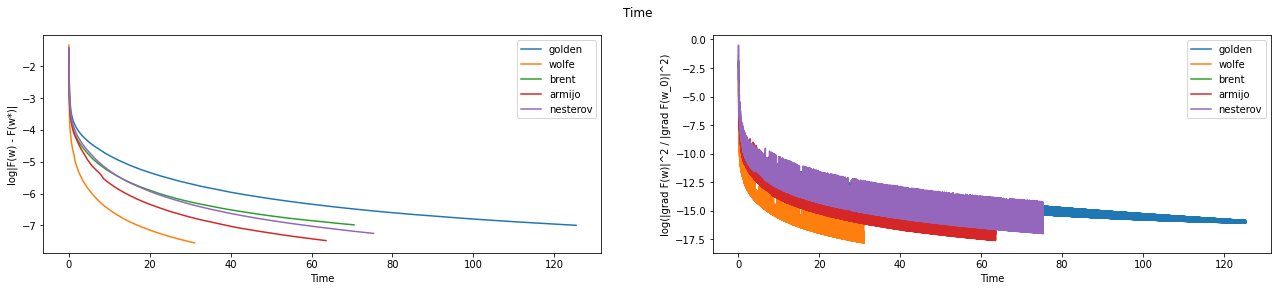

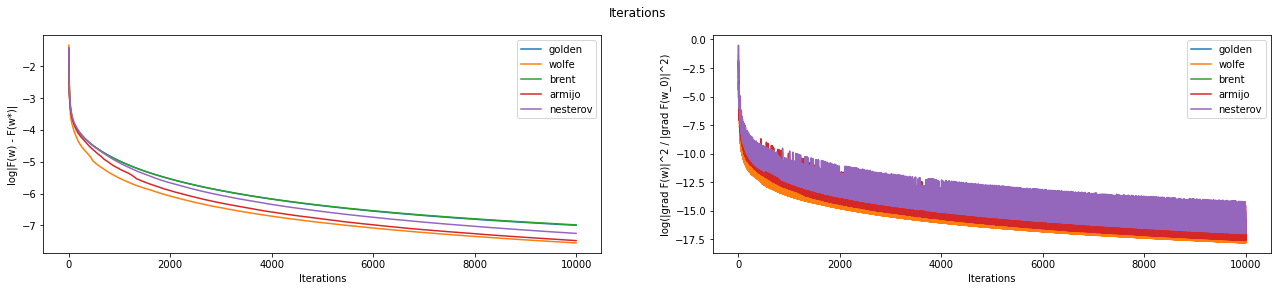

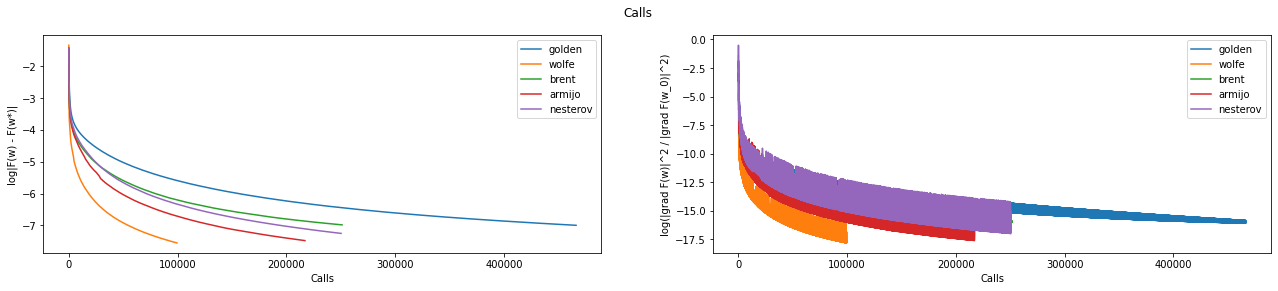

In [13]:
analyze('a1a.txt', optimize, 'zeros', nesterov=True, graph=True)

In [14]:
analyze('a1a.txt', optimize, 'ones', nesterov=True, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.29825  |       5622 |         269910 |  72.04 |
| wolfe    |  0.298391 |      10000 |          99455 |  31.23 |
| brent    |  0.298248 |       5730 |         145525 |  40.78 |
| armijo   |  0.298435 |      10000 |         217104 |  63.57 |
| nesterov |  0.298582 |      10000 |         250179 |  75.04 |


In [15]:
analyze('a1a.txt', optimize, 'random', nesterov=True, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.298252 |       5154 |         247439 |  65.89 |
| wolfe    |  0.298387 |      10000 |          99435 |  30.95 |
| brent    |  0.298252 |       5188 |         131267 |  38.46 |
| armijo   |  0.298429 |      10000 |         217125 |  63.46 |
| nesterov |  0.298567 |      10000 |         250269 |  74.95 |


In [16]:
analyze('breast-cancer_scale.txt', optimize, 'zeros', nesterov=True, graph=False)

Dataset shape:  (683, 10) (683,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   | 0.075457  |        322 |          15819 |   2.21 |
| wolfe    | 0.0754679 |        271 |           3968 |   0.67 |
| brent    | 0.075457  |        322 |           8406 |   1.28 |
| armijo   | 0.0754678 |        172 |           2163 |   0.35 |
| nesterov | 0.0754667 |        145 |           2241 |   0.36 |


In [17]:
analyze('random', optimize, 'zeros', nesterov=True, graph=False)

Dataset shape:  (1000, 1) (1000,)
Unique: [0 1]



| Method   |    Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|------------|------------|----------------|--------|
| golden   | 0.00415044 |       4298 |         211726 |  28.25 |
| wolfe    | 0.00489519 |       2540 |          59063 |   5.85 |
| brent    | 0.00415045 |       4298 |         103403 |  14.16 |
| armijo   | 0.00540858 |      10000 |          70200 |   7.43 |
| nesterov | 0.00490486 |       6521 |          46441 |   5    |


 Быстрее всего работает условие Вульфа. Энтропия примерно везде равна.

# Пункт 4

## Метод Ньютона

In [18]:
def cholesky(A, b, tol):
    A_k = A.copy()
    is_fine = False
    tk = tol

    while not is_fine:
        try:
            L = np.linalg.cholesky(A_k)

            is_fine = True
        except np.linalg.LinAlgError:
            is_fine = False
        
        A_k = A_k + np.eye(A_k.shape[0]) * tk
        tk *= 2

    y = sla.solve(L, b)
    x = sla.solve(L.T.conj(), y)

    return x

In [19]:
def optimize_newton(f, start_point, line_search, tol=1e-08, max_iter=10000):

    W_init = start_point
    W_init_grad = f.grad(W_init)

    W = W_init.copy()

    f.start_count(W_init)
    
    W_grad = f.grad(W)
    W_hessian = f.hessian(W)

    for k in range(max_iter + 1):
        if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < tol:
            break

        direction = cholesky(W_hessian, -W_grad, tol)
        direction_norm = np.linalg.norm(direction)

        if direction_norm > 1000:
            direction = direction / direction_norm

        a = line_search.line_search(W, direction, 1)
        W += a * direction

        W_loss, W_grad, W_hessian = f.fuse_value_grad_hessian(W)
        
        f.next_iteration(W)

    return W

Метод Ньютона для стартовой точки - нулей и датасета a1a

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297875 |         10 |            526 |   1.67 |
| wolfe    |  0.297902 |          7 |             64 |   1.16 |
| brent    |  0.297875 |         10 |            285 |   1.6  |
| armijo   |  0.297902 |          7 |             64 |   1.16 |


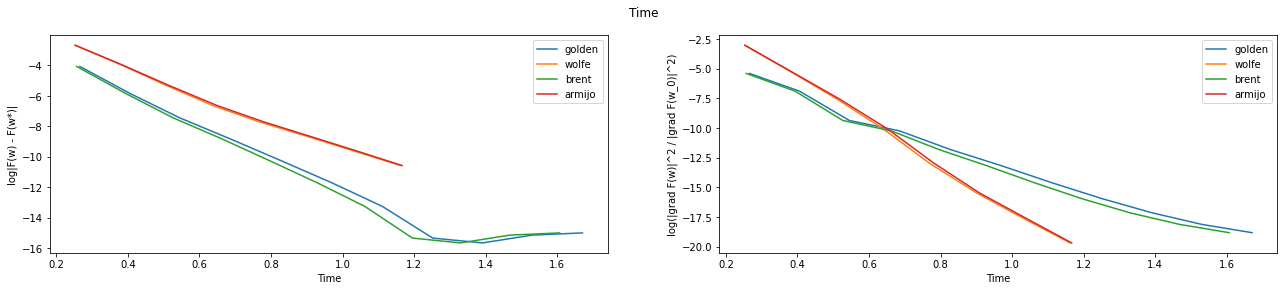

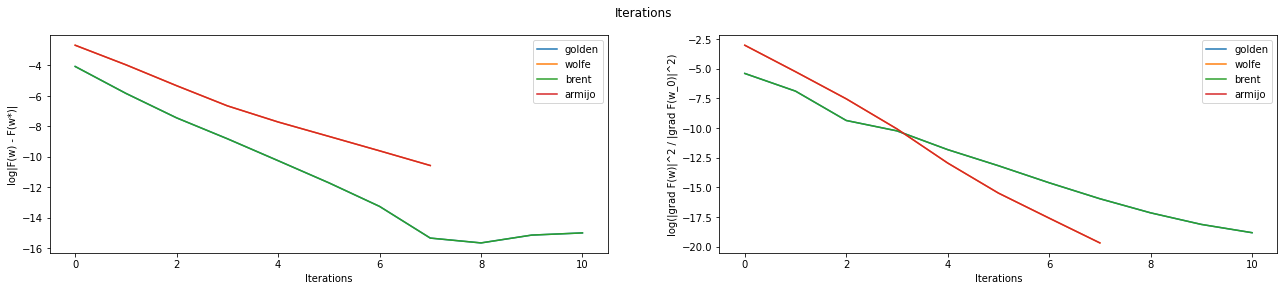

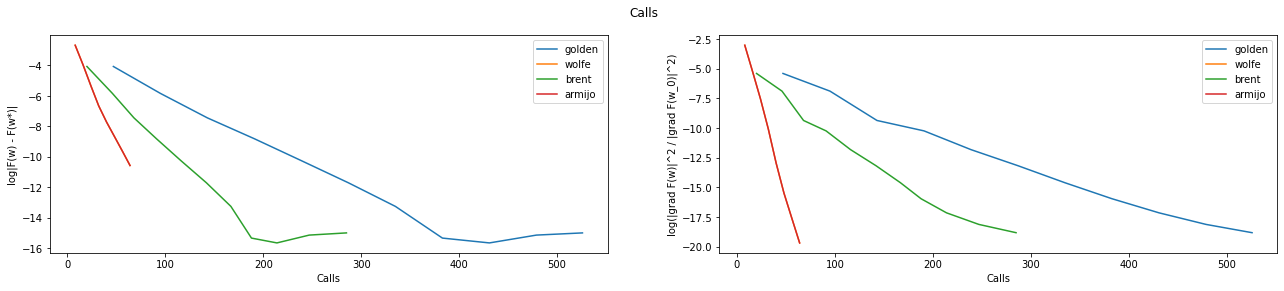

In [20]:
analyze('a1a.txt', optimize_newton, 'zeros', nesterov=False, graph=True)

Метод Ньютона для стартовой точки - единиц и датасета a1a

In [21]:
analyze('a1a.txt', optimize_newton, 'ones', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297876 |         11 |            603 |   1.81 |
| wolfe    |  0.297887 |         25 |            471 |   3.56 |
| brent    |  0.297876 |         11 |            306 |   1.73 |
| armijo   |  0.297879 |         25 |            223 |   3.48 |


Метод Ньютона для стартовой точки - случайных и датасета a1a

In [22]:
analyze('a1a.txt', optimize_newton, 'random', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297876 |          9 |            486 |   1.53 |
| wolfe    |  0.297903 |          8 |            117 |   1.3  |
| brent    |  0.297876 |          9 |            244 |   1.47 |
| armijo   |  0.297906 |          8 |             90 |   1.3  |


Видим, что алгоритм сходится и работает из разных начальных значений!


Breast-Сancer датасет:

In [23]:
analyze('breast-cancer_scale.txt', optimize_newton, 'zeros', nesterov=False, graph=False)

Dataset shape:  (683, 10) (683,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   | 0.0753191 |          3 |            193 |   0.08 |
| wolfe    | 0.0753187 |          6 |             56 |   0.1  |
| brent    | 0.0753191 |          3 |             85 |   0.06 |
| armijo   | 0.0753187 |          6 |             56 |   0.1  |


Датасет со случайными числами:

In [24]:
analyze('random', optimize_newton, 'zeros', nesterov=False, graph=False)

Dataset shape:  (1000, 1) (1000,)
Unique: [0 1]



| Method   |     Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-------------|------------|----------------|--------|
| golden   | -9.9e-09    |          2 |            174 |   0.05 |
| wolfe    |  0.00137215 |         11 |             96 |   0.06 |
| brent    | -9.9e-09    |          2 |            117 |   0.04 |
| armijo   |  0.00137215 |         11 |             96 |   0.05 |


Во время работы также возникало такое, что норма направления была очень большой из-за этого при некоторых начальных значениях не сходилось, поэтому направление нормируется, если его норма очень большая

В зависимости от начального значения, датасета - разные методы лайнсерча показывают себя поразному. Но метод Вульфа опять же показывает себя лучше всех по числу вызовов оракула 

# Пункт 5

## Hessian-Free Newton

In [25]:
def conj_grad(oracle, W, W_grad, tol, start_point):
    x = start_point
    g = oracle.hessian_vec_product(W, x) + W_grad
    d = -g
    stopping_crit = tol * np.linalg.norm(W_grad)
    g_norm = g.T @ g

    n = len(W)

    for i in range(2 * n):
        if np.linalg.norm(g) <= stopping_crit:
            break
            
        prod = oracle.hessian_vec_product(W, d)
        alpha = g_norm / (d @ prod)
        x += alpha * d
        g += alpha * prod

        g_norm_2 = g.T @ g
        beta = g_norm_2 / g_norm
        d = beta * d - g
        g_norm = g_norm_2

    return x

In [26]:
def hfn_optimize(f, start_point, line_search, tol=1e-08, max_iter=10000):

    W_init = start_point
    W_init_grad = f.grad(W_init)

    W = W_init.copy()
    W_grad = W_init_grad.copy()

    f.start_count(W_init)

    for k in range(max_iter + 1):
        
        if np.linalg.norm(W_grad) ** 2 / np.linalg.norm(W_init_grad) ** 2 < tol:
            break

        tol_eta = min(0.5, np.sqrt(np.linalg.norm(W_grad)))
        direction = conj_grad(f, W, W_grad, tol_eta, -W_grad)

        while direction.T @ W_grad >= 0:
            tol_eta /= 10
            direction = conj_grad(f, W, W_grad, tol_eta, direction)

        a = line_search.line_search(W, direction, 1)
        W += a * direction

        W_loss, W_grad = f.fuse_value_grad(W)

        f.next_iteration(W)


    return W

Проверим работоспособность алгоритма:

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297879 |          9 |            850 |   2.35 |
| wolfe    |  0.297909 |          9 |            479 |   2.4  |
| brent    |  0.297879 |          9 |            601 |   2.29 |
| armijo   |  0.297909 |          9 |            479 |   2.35 |


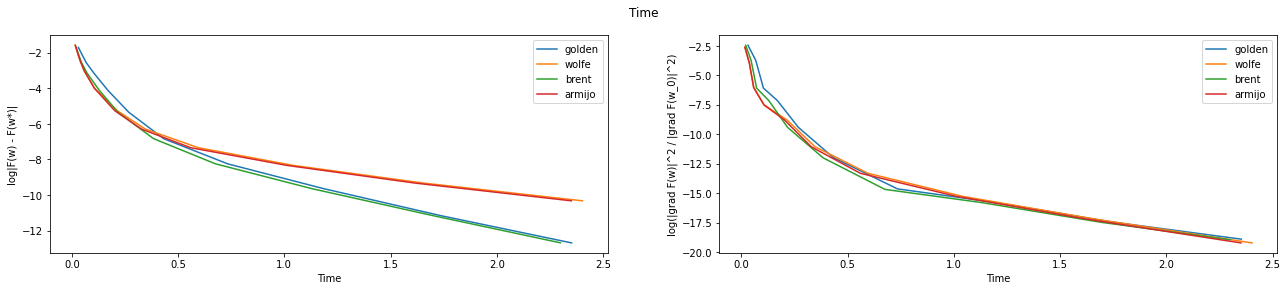

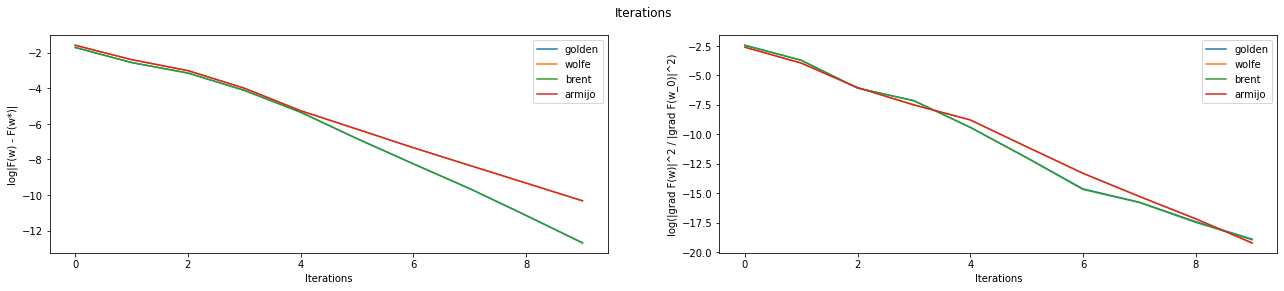

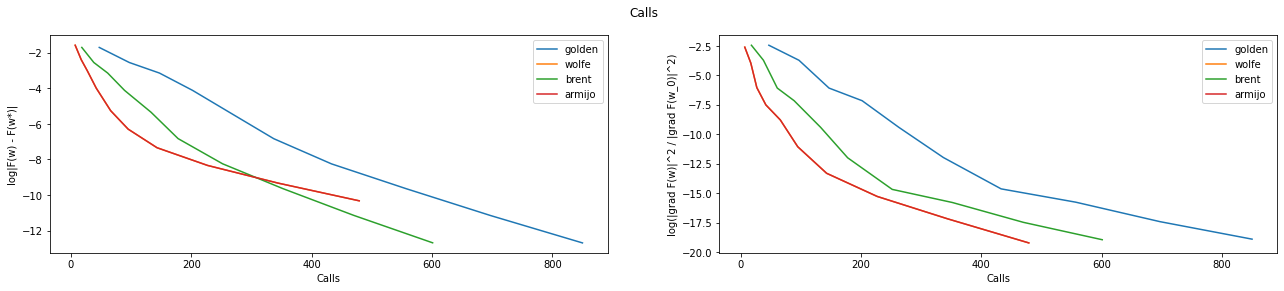

In [27]:
analyze('a1a.txt', hfn_optimize, 'zeros', nesterov=False)

Проверим алгоритм на разных начальных значениях. Сначала запустим из единиц

In [28]:
analyze('a1a.txt', hfn_optimize, 'ones', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297878 |         10 |            957 |   2.79 |
| wolfe    |  0.297904 |         11 |            584 |   2.58 |
| brent    |  0.297878 |         10 |            698 |   2.4  |
| armijo   |  0.297908 |         10 |            584 |   2.65 |


Запустим из случайных весов:

In [29]:
analyze('a1a.txt', hfn_optimize, 'random', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297876 |         10 |           1077 |   3.44 |
| wolfe    |  0.29792  |         11 |            526 |   2.53 |
| brent    |  0.297878 |         10 |            782 |   3.15 |
| armijo   |  0.297901 |         10 |            531 |   2.6  |


Видно, что алгоритм работает при разных начальных значениях.

Теперь проверим его на других датасетах. Breast-cancer датасет:

In [30]:
analyze('breast-cancer_scale.txt', hfn_optimize, 'ones', nesterov=False, graph=False)

Dataset shape:  (683, 10) (683,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   | 0.0753187 |          4 |            273 |   0.09 |
| wolfe    | 0.0753188 |          5 |             82 |   0.06 |
| brent    | 0.0753187 |          4 |            135 |   0.07 |
| armijo   | 0.0753188 |          5 |             82 |   0.07 |


Датасет со случайными числами:

In [31]:
analyze('random', optimize_newton, 'zeros', nesterov=False, graph=False)

Dataset shape:  (1000, 1) (1000,)
Unique: [0 1]



| Method   |     Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-------------|------------|----------------|--------|
| golden   | -9.9e-09    |          0 |             87 |   0.02 |
| wolfe    |  0.00243872 |         11 |             96 |   0.06 |
| brent    | -9.9e-09    |          0 |             83 |   0.02 |
| armijo   |  0.00243872 |         11 |             96 |   0.06 |


Алгоритм буквально за 10 итераций сходится почти всегда. Меньше всего итераций происходит при использовании условия Вульфа.

## Сравнение

In [32]:
analyze('a1a.txt', hfn_optimize, 'zeros', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297879 |          9 |            850 |   2.58 |
| wolfe    |  0.297909 |          9 |            479 |   2.67 |
| brent    |  0.297879 |          9 |            601 |   2.57 |
| armijo   |  0.297909 |          9 |            479 |   2.82 |


In [33]:
analyze('a1a.txt', optimize_newton, 'zeros', nesterov=False, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.297875 |         10 |            526 |   1.67 |
| wolfe    |  0.297902 |          7 |             64 |   1.16 |
| brent    |  0.297875 |         10 |            285 |   1.61 |
| armijo   |  0.297902 |          7 |             64 |   1.16 |


In [34]:
analyze('a1a.txt', optimize, 'zeros', nesterov=True, graph=False)

Dataset shape:  (1605, 119) (1605,)



| Method   |   Entropy |   Num Iter |   Oracle Calls |   Time |
|----------|-----------|------------|----------------|--------|
| golden   |  0.298791 |      10000 |         466398 | 125.65 |
| wolfe    |  0.298402 |      10000 |          99437 |  30.97 |
| brent    |  0.298804 |      10000 |         251263 |  70.73 |
| armijo   |  0.298442 |      10000 |         217065 |  63.52 |
| nesterov |  0.298586 |      10000 |         250302 |  75.24 |


Если сравнивать алгоритмы друг с другом, то градиентный спуск на порядок работает медленнее всех остальных. HFN работает дольше, чем обычный Ньютон, т.к. у него больше вызовов оракула из-за метода сопряженных градиентов. По итоговой энтропии все алгоритмы работает примерно одинаково.